In [1]:
from functools import partial
from time import time
from dataclasses import replace
import pandas as pd
import numpy.typing as npt
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from bar_1d import BarInputDynamics
from dynamics import BarDynamics, C0BarDynamics, DynamicsResults
from lame import calc_lambda, calc_mu
from c0_basis import calc_ecsi_placement_coords_gauss_lobato
from nomeclature import X_COORD, NUM_DISPLACEMENT, DEGREE, N_STEPS, ELAPSED_TIME
from bar_1d import EnergyNormsAndErrors

In [2]:
t0 = time()
young_modulus = 210e9
poisson = 0.3
lame_lambda = calc_lambda(young_modulus=young_modulus, poisson=poisson)
lame_mu = calc_mu(young_modulus=young_modulus, poisson=poisson)
density = 7850
section_area = 1.0e-3
length = 4.0
n_elements = 10
degree = 1
t_initial = 0.0
t_final = 0.2
n_steps = 15000

x, t, p, lambda_, mu, cp, A, rho = sy.symbols("x t p lambda mu C_p A rho")
displacement_analytical_symb = (0.2 + 0.2 * sy.sin(t)) * p + 0.1 * sy.sin(0.01 * p)
displacement_derivative_symb = sy.diff(displacement_analytical_symb, p)
displacement_derivative_num = sy.lambdify([p, t], displacement_derivative_symb)
velocity_analytical_symb = sy.diff(displacement_analytical_symb, t)
disp_num = sy.lambdify([p, t], displacement_analytical_symb)
velocity_num = sy.lambdify([p, t], velocity_analytical_symb)
grad_p = 1 + sy.diff(displacement_analytical_symb, p)
cauchy_green = grad_p**2
stress_piolla_kirchhoff_2 = mu * (1 - 1 / cp) + lambda_ * sy.ln(sy.sqrt(cp)) / cp
stress_piolla_kirchhoff_2 = stress_piolla_kirchhoff_2.subs(cp, cauchy_green)
stress_piolla_kirchhoff_2_num = sy.lambdify(
    [p, t],
    stress_piolla_kirchhoff_2.subs(
        {A: section_area, lambda_: lame_lambda, mu: lame_mu, p: length}
    ),
)
stress_piolla_kirchhoff_1 = stress_piolla_kirchhoff_2 * grad_p
normal_piolla_kirchhoff_1 = A * stress_piolla_kirchhoff_1
normal_piolla_kirchhoff_1 = normal_piolla_kirchhoff_1.simplify()

dist_load = -sy.diff(normal_piolla_kirchhoff_1, p) + rho * A * sy.diff(
    displacement_analytical_symb, t, 2
)
dist_load_num = sy.lambdify(
    [p, t],
    dist_load.subs({lambda_: lame_lambda, mu: lame_mu, A: section_area, rho: density}),
)
# load_at_end = normal_piolla_kirchhoff_1.subs(
#     {A: section_area, lambda_: lame_lambda, mu: lame_mu, p: length, rho: density}
# )
load_at_end_num = sy.lambdify(
    t,
    normal_piolla_kirchhoff_1.subs(
        {
            A: section_area,
            lambda_: lame_lambda,
            mu: lame_mu,
            p: length,
            rho: density,
        }
    ),
)
displacement_analytical_final_t = displacement_analytical_symb.subs({t: t_final})
l2_norm = (
    sy.integrate(displacement_analytical_final_t**2, (t, t_initial, t_final)) ** 0.5
)
h1_norm = (
    sy.integrate(sy.diff(displacement_analytical_final_t, p) ** 2, (p, 0.0, length))
    ** 0.5
)

bar = BarInputDynamics(
    young_modulus=young_modulus,
    poisson=poisson,
    density=density,
    section_area=section_area,
    length=length,
    degree=degree,
    n_elements=n_elements,
)

bar_dynamics_c0 = C0BarDynamics(
    bar=bar, ecsi_placement_coords_function=calc_ecsi_placement_coords_gauss_lobato
)

analysis = BarDynamics(
    data=bar_dynamics_c0,
    dist_load_function=dist_load_num,
    normal_force_pk_1_at_end_function_t=load_at_end_num,
    disp_function_p_t=disp_num,
    disp_derivative_function_p_t=displacement_derivative_num,
    velocity_function_p_t=velocity_num,
    t_initial=t_initial,
    t_final=t_final,
    n_time_steps=n_steps,
)

analysis_nm = BarDynamics(
    data=bar_dynamics_c0,
    dist_load_function=dist_load_num,
    normal_force_pk_1_at_end_function_t=load_at_end_num,
    disp_function_p_t=disp_num,
    disp_derivative_function_p_t=displacement_derivative_num,
    velocity_function_p_t=velocity_num,
    t_initial=t_initial,
    t_final=t_final,
    n_time_steps=100,
)


error_df = pd.DataFrame()
delta_t = time() - t0


def get_results(
    analysis: BarDynamics, error_norms: EnergyNormsAndErrors, res: DynamicsResults
):
    error = error_norms.df
    return pd.concat(
        [
            pd.DataFrame(
                {
                    N_STEPS: [analysis.n_time_steps],
                    DEGREE: [analysis.data.bar.degree],
                    ELAPSED_TIME: [res.elapsed_time],
                }
            ),
            error,
        ],
        axis=1,
    )


def get_sorted_displacement(
    displacements: npt.NDArray[np.float64], p_coords: npt.NDArray[np.float64]
):
    return pd.DataFrame(
        {X_COORD: p_coords, NUM_DISPLACEMENT: displacements}
    ).sort_values(X_COORD)


pre_calc_sorted_displacement = partial(
    get_sorted_displacement, p_coords=analysis.pre_process.p_coords
)

   n_steps  degree  elapsed_time  l2_error_norm  l2_sol_norm  h1_error_norm  \
0    20000       1     87.557418   9.122391e-06     1.111892   3.859460e-06   
0      100       1      0.822000   6.270899e-09     1.111901   5.325816e-08   
0    20000       2     94.513028   7.530852e-06     1.111894   3.135769e-06   
0      100       2      0.937000   1.311916e-10     1.111901   1.193104e-09   
0    20000       4    113.589991   7.531420e-06     1.111894   3.189333e-06   
0      100       4      1.305009   1.135007e-10     1.111901   4.507836e-11   

   h1_sol_norm  
0     0.481464  
0     0.481467  
0     0.481465  
0     0.481467  
0     0.481465  
0     0.481467  


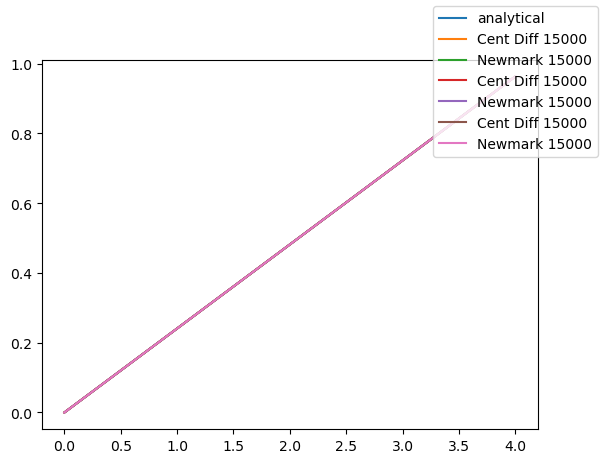

In [3]:
fig, ax = plt.subplots()
disp_t_final = sy.lambdify(p, displacement_analytical_symb.subs({t: t_final}))
x = np.linspace(0, length, 101)
u = disp_t_final(x)
ax.plot(x, u, label="analytical")

t1 = time()
# t_steps = [10000, 7500, 5000, 2500]
degrees = [1, 2, 4]
for degree in degrees:
    bar = replace(bar, degree=degree)
    bar_dynamics_c0 = C0BarDynamics(
        bar=bar, ecsi_placement_coords_function=calc_ecsi_placement_coords_gauss_lobato
    )
    analysis = BarDynamics(
        data=bar_dynamics_c0,
        dist_load_function=dist_load_num,
        normal_force_pk_1_at_end_function_t=load_at_end_num,
        disp_function_p_t=disp_num,
        disp_derivative_function_p_t=displacement_derivative_num,
        velocity_function_p_t=velocity_num,
        t_initial=t_initial,
        t_final=t_final,
        n_time_steps=20000,
    )
    pre_calc_sorted_displacement = partial(
        get_sorted_displacement, p_coords=analysis.pre_process.p_coords
    )
    error = analysis.error_norms_central_difference
    error_df = pd.concat(
        [error_df, get_results(analysis, error, analysis.results_central_difference)]
    )
    displacement_df = pre_calc_sorted_displacement(
        analysis.results_central_difference.displacements[-1, :]
    )
    ax.plot(
        displacement_df[X_COORD],
        displacement_df[NUM_DISPLACEMENT],
        label=f"Cent Diff {n_steps}",
    )

    analysis = BarDynamics(
        data=bar_dynamics_c0,
        dist_load_function=dist_load_num,
        normal_force_pk_1_at_end_function_t=load_at_end_num,
        disp_function_p_t=disp_num,
        disp_derivative_function_p_t=displacement_derivative_num,
        velocity_function_p_t=velocity_num,
        t_initial=t_initial,
        t_final=t_final,
        n_time_steps=100,
    )
    error = analysis.error_norms_newmark
    error_df = pd.concat(
        [error_df, get_results(analysis, error, analysis.results_newmark)]
    )
    displacement_df = pre_calc_sorted_displacement(
        analysis.results_newmark.displacements[-1, :]
    )
    ax.plot(
        displacement_df[X_COORD],
        displacement_df[NUM_DISPLACEMENT],
        label=f"Newmark {n_steps}",
    )


# t_steps = [15000]
# for n_steps in t_steps:
#     analysis = replace(analysis, n_time_steps=n_steps)
#     error = analysis.error_norms_central_difference
#     error_df = pd.concat(
#         [error_df, get_results(analysis, error, analysis.results_central_difference)]
#     )
#     displacement_df = pre_calc_sorted_displacement(
#         analysis.results_central_difference.displacements[-1, :]
#     )
#     ax.plot(
#         displacement_df[X_COORD],
#         displacement_df[NUM_DISPLACEMENT],
#         label=f"Central Diff {n_steps}",
#     )


# t_steps = [100, 10, 5]
# for n_steps in t_steps:
#     analysis = replace(analysis, n_time_steps=n_steps)
#     error = analysis.error_norms_newmark
#     error_df = pd.concat(
#         [error_df, get_results(analysis, error, analysis.results_newmark)]
#     )
#     displacement_df = pre_calc_sorted_displacement(
#         analysis.results_newmark.displacements[-1, :]
#     )
#     ax.plot(
#         displacement_df[X_COORD],
#         displacement_df[NUM_DISPLACEMENT],
#         label=f"Newmark {n_steps}",
#     )

fig.legend()
delta_t2 = time() - t1
print(error_df)


# # res_central_difference = analysis.results_central_difference
# res_newmark = analysis.results_newmark

# displacements_newmark = res_newmark.displacements[-1, :]
# # displacements_central_diff = res_central_difference.displacements[-1, :]
# p_coord = analysis.pre_process.p_coords
# df_newmark = pd.DataFrame(
#     {X_COORD: p_coord, NUM_DISPLACEMENT: displacements_newmark}
# ).sort_values(X_COORD)
# # df_central_diff = pd.DataFrame(
# #     {X_COORD: p_coord, NUM_DISPLACEMENT: displacements_central_diff}
# # ).sort_values(X_COORD)
# fig, ax = plt.subplots()

# disp_t_final = sy.lambdify(p, displacement_analytical_symb.subs({t: t_final}))
# # x = np.linspace(0, length, 21)
# u = disp_t_final(df_newmark[X_COORD])

# # for t_step in np.linspace(0, 0.2, 6):
# #     disp_t0 = sy.lambdify(p, displacement_analytical_symb.subs({t: t_step}))
# #     u = disp_t0(x)
# #     ax.plot(x, u, label=f"t {t}s")

# ax.plot(df_newmark[X_COORD], df_newmark[NUM_DISPLACEMENT], label="newmark")
# # ax.plot(
# #     df_central_diff[X_COORD], df_central_diff[NUM_DISPLACEMENT], label="central dif"
# # )
# ax.plot(df_newmark[X_COORD], u, label="analytical")

# fig.legend()

# print(
#     f"execution time newmark: {res_newmark.elapsed_time}"
# )

# errors = analysis.error_norms_newmark.df
# print(errors)
# profiler.print_stats()